# Assignment 2

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

sns.set_theme(context="poster", style="darkgrid", palette="colorblind")

torch.manual_seed(1)
np.random.seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.deterministic = True

## Load the data

In [ ]:
WIND_SPEED = 0
WIND_DIR = 1
TEMPERATURE = 2
DEW_POINT = 3
AIR_PRESSURE = 4

In [ ]:
mat = scipy.io.loadmat("data.mat")["X"]

In [ ]:
mat.shape

(70128, 4, 5)

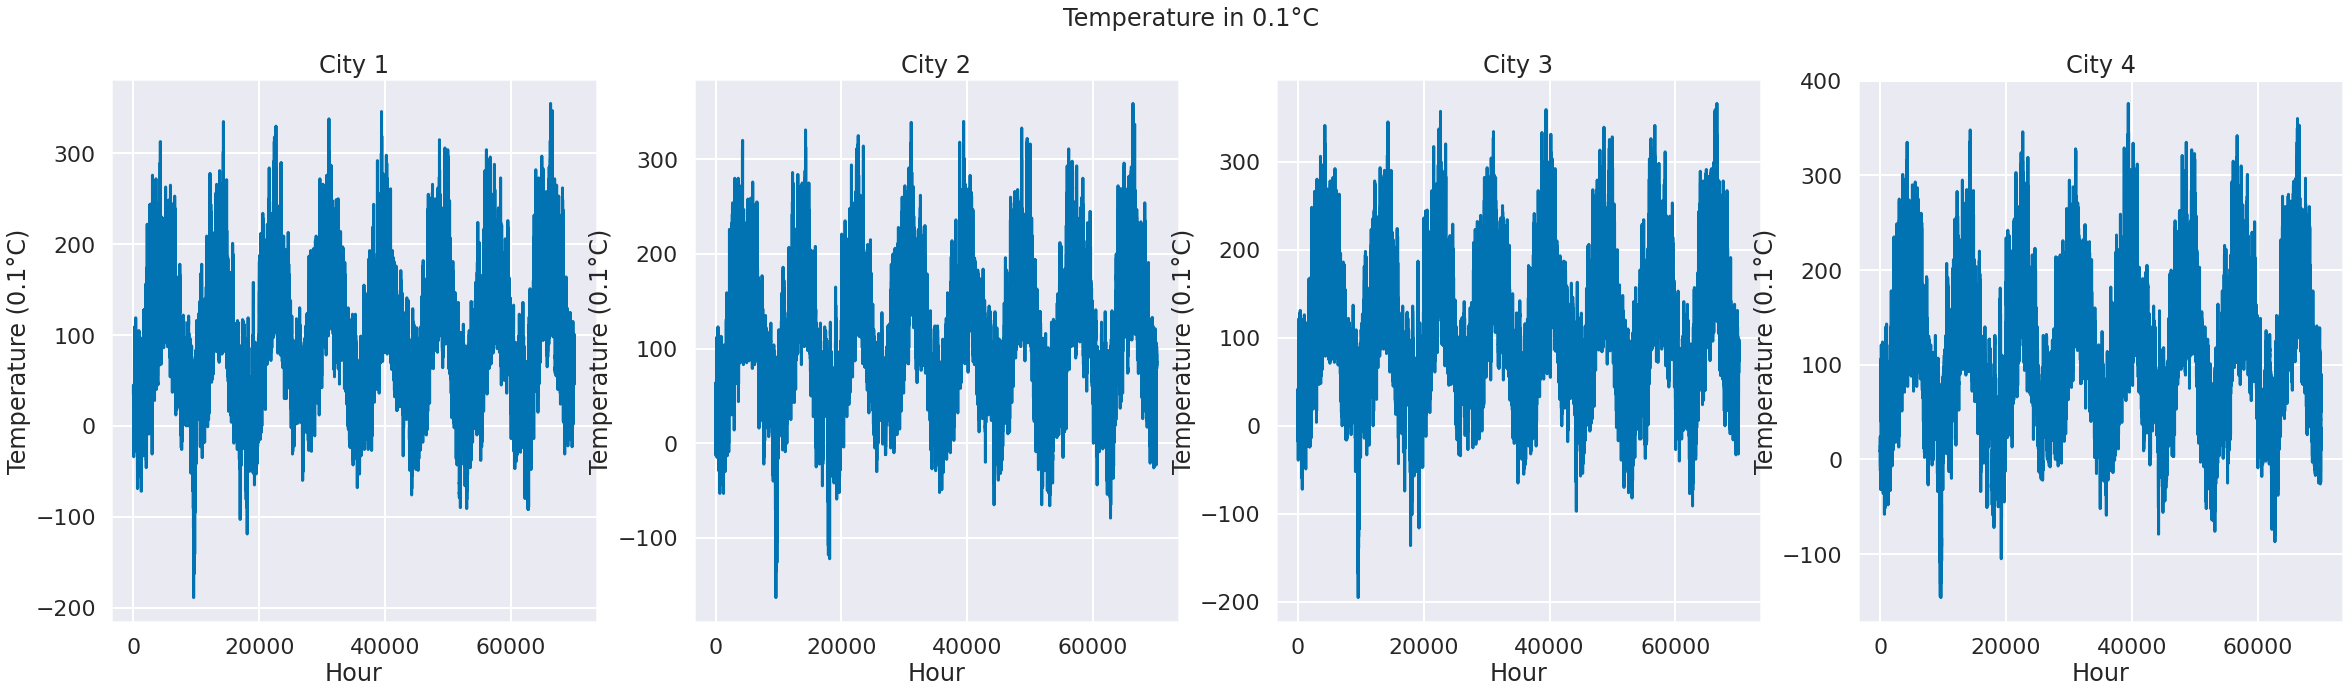

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(40,10))
fig.suptitle("Temperature in 0.1°C", fontsize=24)
for j in range(4):
        axs[j].plot(mat[:, j, 2], )
        axs[j].set_title(f"City {j+1}")
        axs[j].set_xlabel("Hour")
        axs[j].set_ylabel("Temperature (0.1°C)")
plt.show()

## Make the dataset

In [ ]:
def split_train_test(data, test_size=168):
    train = data[:-test_size, :, :].copy()
    test = data[-test_size:, :,:].copy()
    return train, test

In [ ]:
def scale(data, range=(0, 1)):
    if type(data) == torch.Tensor:
        data = data.clone()
    else:
        data = data.copy()
    max_ = data.max(axis=(0,1))
    min_ = data.min(axis=(0,1))
    data = (data - min_) / (max_ - min_)
    data = data * (range[1] - range[0]) + range[0]
    return data, max_, min_

def scale_back(data, max_, min_, range=(0, 1)):
    if type(data) == torch.Tensor:
        data = data.detach().clone()
    else:
        data = data.copy()
    data = (data - range[0])/(range[1] - range[0])
    data = data * (max_ - min_) + min_
    return data

In [ ]:
data, max_, min_ = scale(mat)
train, test = split_train_test(data)
train, val = split_train_test(train)

In [ ]:
def make_dataset(data, window_size, shuffle = False):
    """
    Organize the data in such a way we can use it for training
    """
    # ----------------------------------------------------
        
    X_train = np.lib.stride_tricks.sliding_window_view(data[:-1].copy(), window_size, axis=0)
    Y_train= data[window_size:,:,:].copy()
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    
    if shuffle:        
        train_perm = torch.randperm(X_train.shape[0])
        X_train = X_train[train_perm]
        Y_train = Y_train[train_perm]
        
    #X_train = X_train.reshape(-1, 1, 1)

    return X_train, Y_train

def reshape_for_lstm(x, y):
    """
    From a shape (n, 4, 5, window) to (window, n*4, 5)
    """
    n, cities, features, window = x.shape    
    x = x.reshape(-1, features, window)
    x = torch.permute(x, (2, 0, 1))
    y = y.reshape(-1, 5)
    return x, y

def reshape_for_cnn(x, y):
    """
    From a shape (n, 4, 5, window) to (n * 4, 5, window)
    """
    n, cities, features, window = x.shape    
    x = x.reshape(-1, features, window)
    y = y.reshape(-1, 5)
    return x, y

## Define the models

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, window, layers=1, dropout=0.5):
          super().__init__()
          self.window = window
          self.hidden = hidden_size
          self.input = input_size
          # The LSTM takes sequences as inputs, and outputs the predicted value
          # with dimensionality hidden_size.
          self.lstm = nn.LSTM(input_size, hidden_size, layers)

          #connection to the dropout layer
          self.dropout = nn.Dropout(dropout)

          # The layer that maps from hidden state space to output space
          self.hidden2output = nn.Linear(hidden_size * window, output_size) 


    def forward(self, x):
        lstm_out, _ = self.lstm(x)        
        dropout = self.dropout(lstm_out.view(-1, self.hidden * self.window))
        output = self.hidden2output(dropout) 
        return F.relu(output)      
        
    def predict(self, x, n=168):
        output = torch.cat((x, torch.zeros(n, device = x.device)))
        for i in range(n):
            sequence = output[i: i + x.shape[0]]
            prediction = self(sequence)
            output[i + x.shape[0]] = prediction
        return output[-n:]

class ResidualBlock(nn.Module):
    def __init__(self, in_size, hidden_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_size, hidden_size, 3, padding=1, bias=True)
        self.conv2 = nn.Conv1d(hidden_size, in_size, 3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(in_size)
    
    def forward(self, data):
        x = self.conv1(data)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + data
        return F.relu(x)
        
class CNNModel(nn.Module):
    # def __init__(self):
    #     super().__init__()

    #     self.cnn_layers = nn.Sequential(
    #         # Defining a 2D convolution layer
    #         nn.Conv2d(5, 10, kernel_size=3, stride=1, padding=1),
    #         nn.BatchNorm2d(10),
    #         nn.ReLU(inplace=True),
    #         nn.MaxPool2d(kernel_size=2, stride=2),
    #         # Defining another 2D convolution layer
    #         nn.Conv2d(10, 4, kernel_size=3, stride=1, padding=1),
    #         nn.BatchNorm2d(4),
    #         nn.ReLU(inplace=True),
    #         nn.MaxPool2d(kernel_size=2, stride=2),
    #     )

    #     self.linear_layers = nn.Sequential(
    #         nn.Linear(4 * 37 * 5, 5)
    #     )
    
    # def forward(self, x):
    #     x = self.cnn_layers(x)
    #     print(x.shape)
    #     x = x.view(x.size(0), -1)
    #     x = self.linear_layers(x)
    #     return x
    def __init__(self, features, hidden_size, residual_bocks, window_size):
        super().__init__()
        self.cnn_layers = nn.Sequential(*[ResidualBlock(features, hidden_size) for i in range(residual_bocks)])
        self.linear_layers = nn.Sequential(nn.Linear(window_size * features, features))
    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.flatten(1)  # Number of elements x (features * window size)
        return self.linear_layers(x)

    def predict(self, x, n=168):
        z = torch.zeros((5, n), device = x.device)

        output = torch.cat((x, z), dim=1)        
        for i in range(n):
            sequence = output[:, i: i + x.shape[1]].reshape(1, 5, -1)
            prediction = self(sequence).T.reshape(-1)
            output[:, i + x.shape[1]] = prediction
        return output[:, -n:]


## Training the models

In [ ]:
def training(x_train, y_train, x_val, y_val, model, optimizer, criterion, epochs):
    model.train()
    losses = [0 for e in range(epochs)]
    val_losses = [0 for e in range(epochs)]
    
    for e in range(epochs):         
        y_pred = model(x_train)            
        loss = criterion(y_pred, y_train)        
        losses[e] = loss.item()        
        
        if e % 100 == 99:
            print(f"Epoch {e+1}:", loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if x_val.shape[0] != 0:
            y_pred_val = model(x_val)
            val_loss = criterion(y_pred_val, y_val)
            val_losses[e] = val_loss.item()
    return losses, val_losses

def testing(x, y, model, criterions, min_= None, max_= None):
    model.eval()
    y_pred = model(x)
    
    if min_ is not None and max_ is not None:
        y_pred = scale_back(y_pred, min_, max_)
        y = scale_back(y, min_, max_)

    if isinstance(criterions, list) or isinstance(criterions, tuple):
        loss = [i(y_pred, y).item() for i in criterions]
    else:
        loss =criterions(y_pred, y).item()
    return loss, y, y_pred

def load(path):
    model = torch.load(path)
    model.eval()
    return model

def save(model, path):
    torch.save(model, path)

def plot_loss(title, loss, val_loss):
    plt.figure(figsize=(10, 8))
    plt.plot(loss, label="Train")
    plt.plot(val_loss, label="Validation")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

def plot_predictions(title, y, y_pred):
    y = y.clone().cpu()
    y_pred = y_pred.clone().cpu()
    y = y.reshape(-1).detach().numpy()
    y_pred = y_pred.reshape(-1).detach().numpy()    

    plt.figure(figsize=(10, 8))
    plt.plot(y, label="y")
    plt.plot(y_pred, label="prediction")
    plt.title(title)
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


In [ ]:
def make_RMSE():
    mse = nn.MSELoss()
    def RMSE(y_pred, y):
        return torch.sqrt(mse(y_pred, y))
    return RMSE


Epoch 100: 0.03764064237475395
Epoch 200: 0.03152866289019585


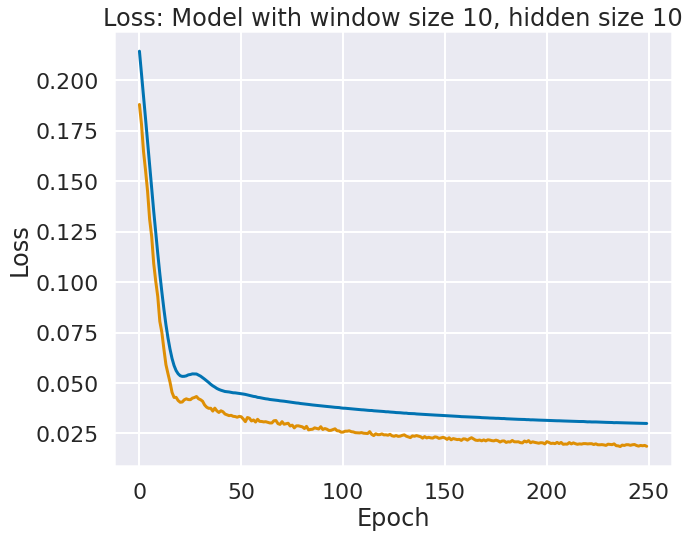

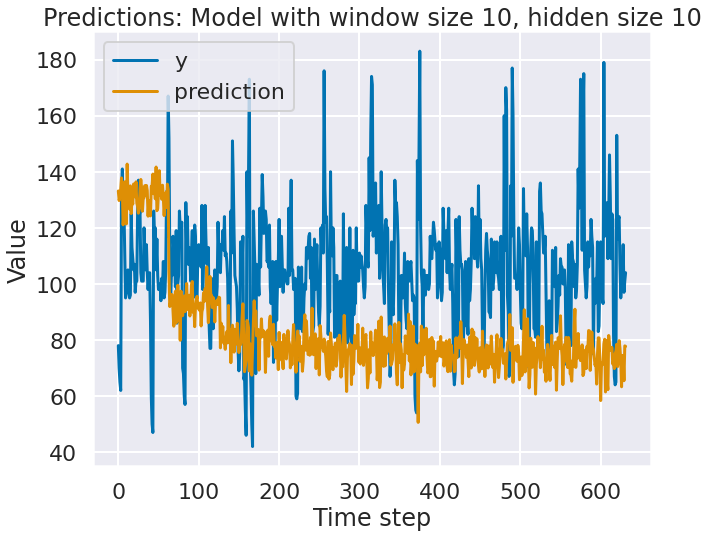

Loss (MSE): 4912.1982421875
------------------------------------------------------
Epoch 100: 0.03418890759348869
Epoch 200: 0.028249984607100487


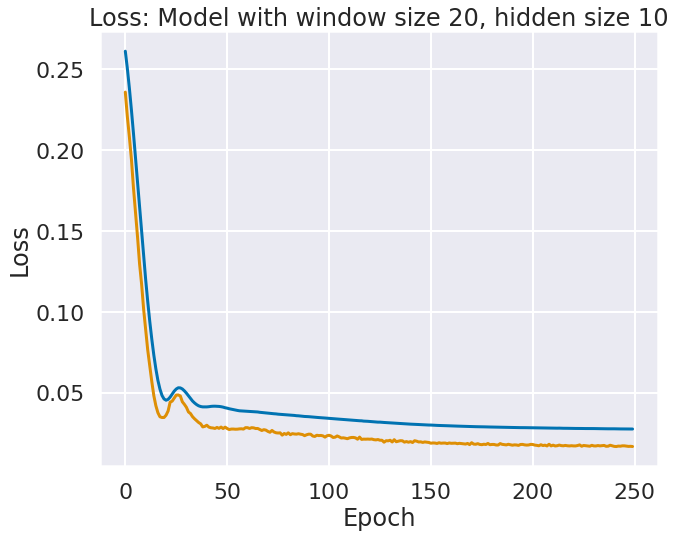

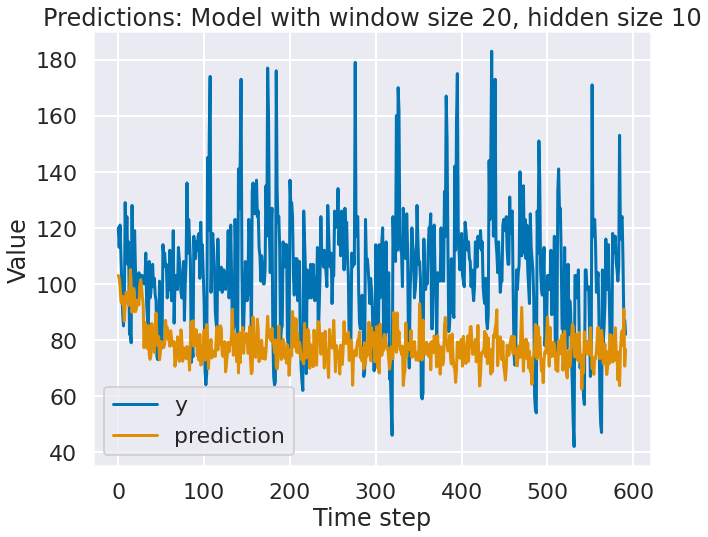

Loss (MSE): 4669.89208984375
------------------------------------------------------
Epoch 100: 0.02991556189954281
Epoch 200: 0.027858911082148552


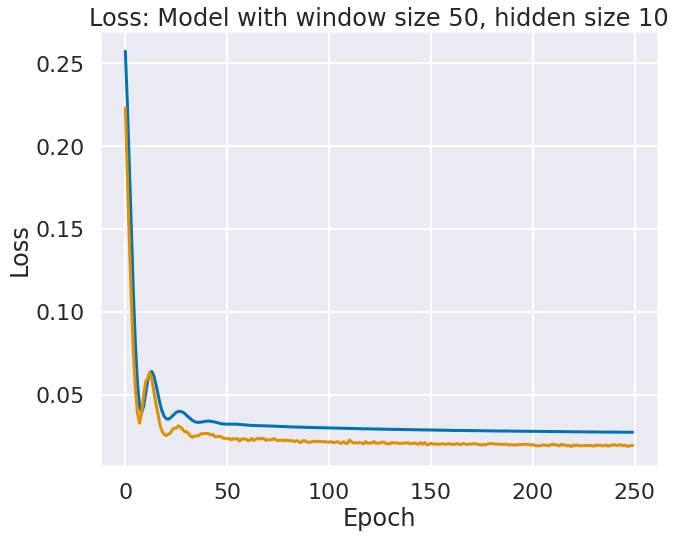

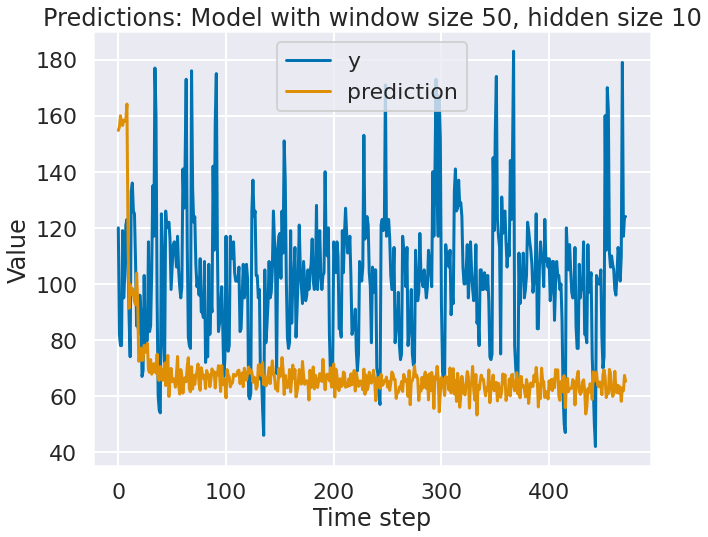

Loss (MSE): 5618.0009765625
------------------------------------------------------


In [ ]:
window_size = [10, 20, 50]
hidden_size = 10
output_size =5
epochs = 250
val_size = 50

for i in window_size:
    lstm = LSTMModel(5, hidden_size, output_size, window=i).to(device)
    X_train, Y_train = make_dataset(train, i, shuffle=True)
    X_train, Y_train = reshape_for_lstm(X_train, Y_train)
    X_val, Y_val = make_dataset(val, i, shuffle=True)
    X_val, Y_val = reshape_for_lstm(X_val, Y_val)
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)
    
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(lstm.parameters())
    losses, val_losses = training(X_train, Y_train, X_val, Y_val, lstm, optimizer, criterion, epochs)
    loss, y, y_pred = testing(X_val, Y_val, lstm, criterion, min_[TEMPERATURE], max_[TEMPERATURE])
    plot_loss(f"Loss: Model with window size {i}, hidden size {hidden_size}", losses, val_losses)
    plot_predictions(f"Predictions: Model with window size {i}, hidden size {hidden_size}", y[:, TEMPERATURE], y_pred[:, TEMPERATURE])
    save(lstm, f"/content/window_size{i}_hidden_size{hidden_size}_epochs{epochs}_lstm.pt")
    print("Loss (MSE):", loss)
    print("------------------------------------------------------") 
    del lstm
    del X_train
    del Y_train

Epoch 100: 0.02823042869567871
Epoch 200: 0.017973298206925392
Epoch 300: 0.014238606207072735
Epoch 400: 0.012293829582631588
Epoch 500: 0.011086078360676765
Epoch 600: 0.010266936384141445
Epoch 700: 0.009672442451119423
Epoch 800: 0.009210105985403061
Epoch 900: 0.008835515938699245
Epoch 1000: 0.008528229780495167


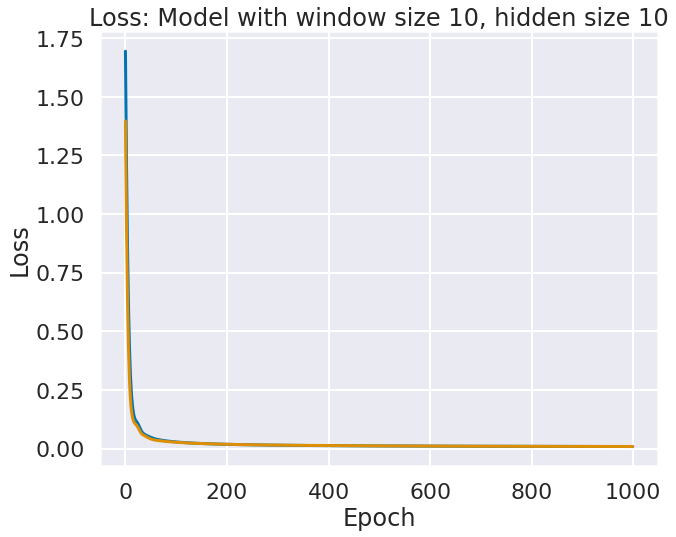

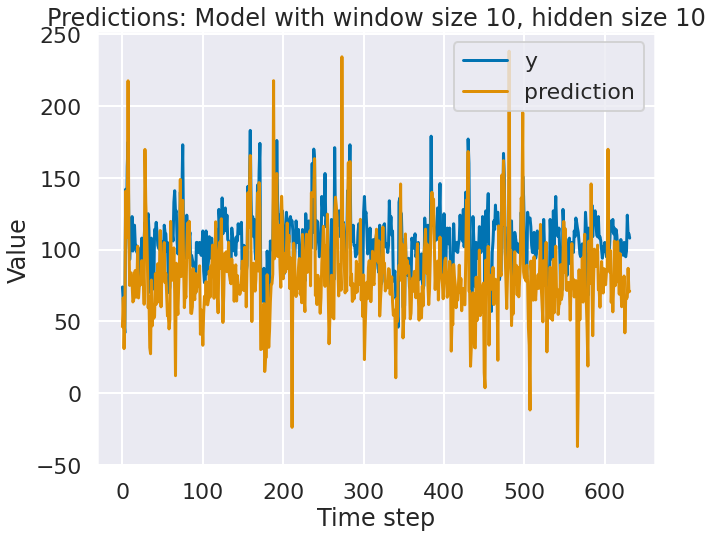

Loss (MSE): 2107.229248046875
------------------------------------------------------
Epoch 100: 0.02603193372488022
Epoch 200: 0.015829406678676605
Epoch 300: 0.012364917434751987
Epoch 400: 0.010621893219649792
Epoch 500: 0.009540277533233166
Epoch 600: 0.008839229121804237
Epoch 700: 0.0083548529073596
Epoch 800: 0.007996710017323494
Epoch 900: 0.007718802895396948
Epoch 1000: 0.007495170459151268


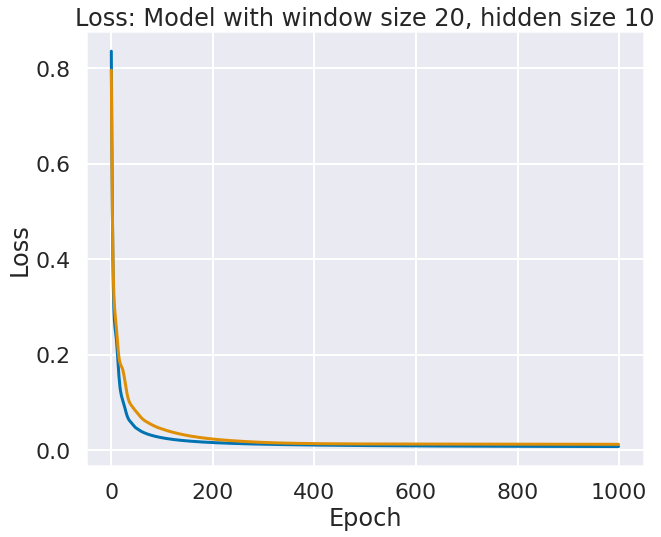

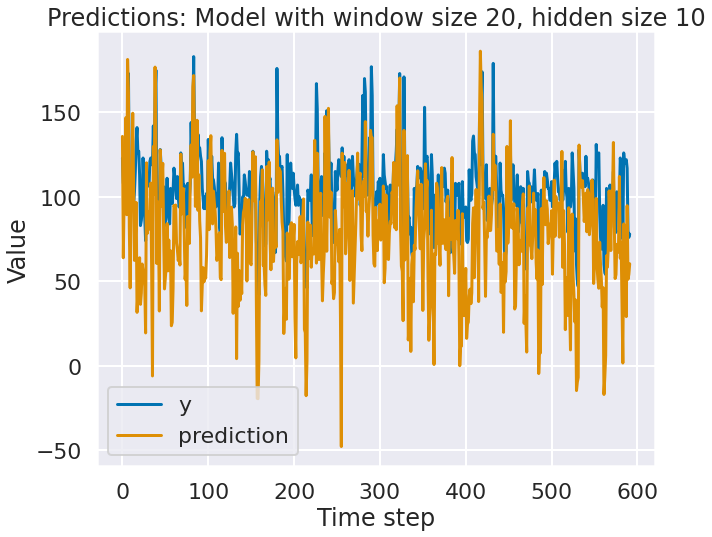

Loss (MSE): 2174.03515625
------------------------------------------------------
Epoch 100: 0.032823484390974045
Epoch 200: 0.019134845584630966
Epoch 300: 0.014951230958104134
Epoch 400: 0.012843788601458073
Epoch 500: 0.011523081921041012
Epoch 600: 0.010603229515254498
Epoch 700: 0.00989933218806982
Epoch 800: 0.009332089684903622
Epoch 900: 0.008863833732903004
Epoch 1000: 0.008472434245049953


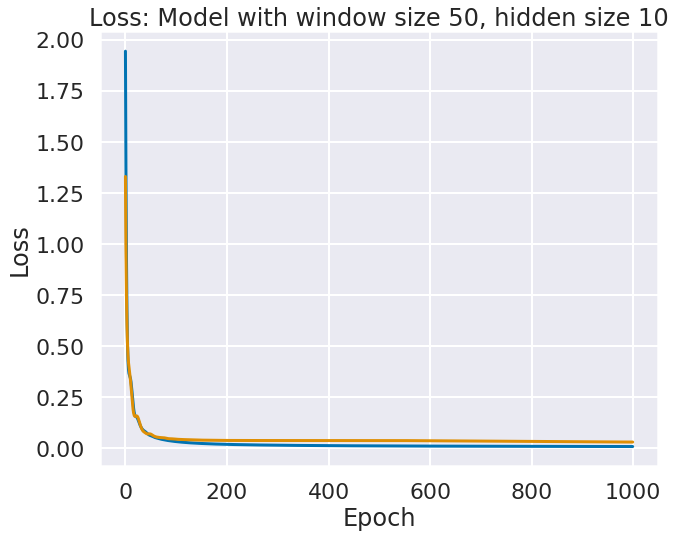

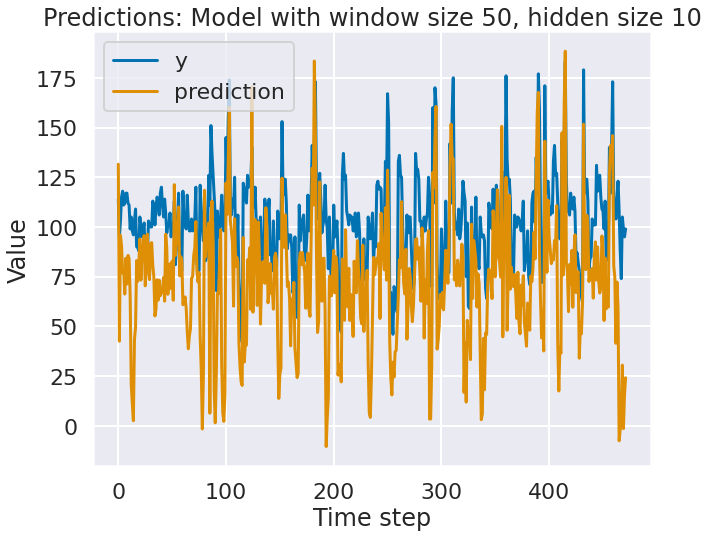

Loss (MSE): 3197.140380859375
------------------------------------------------------


In [ ]:
window_size = [10, 20, 50]
hidden_size = 10
output_size =5
epochs = 1000
val_size = 50

for i in window_size:    
    cnn = CNNModel(5, hidden_size, 3, i).to(device)
    X_train, Y_train = make_dataset(train, i, shuffle=True)
    X_train, Y_train = reshape_for_cnn(X_train, Y_train)
    X_val, Y_val = make_dataset(val, i, shuffle=True)
    X_val, Y_val = reshape_for_cnn(X_val, Y_val)
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)
    
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(cnn.parameters())
    losses, val_losses = training(X_train, Y_train, X_val, Y_val, cnn, optimizer, criterion, epochs)
    loss, y, y_pred = testing(X_val, Y_val, cnn, criterion, min_[TEMPERATURE], max_[TEMPERATURE])
    plot_loss(f"Loss: Model with window size {i}, hidden size {hidden_size}", losses, val_losses)
    plot_predictions(f"Predictions: Model with window size {i}, hidden size {hidden_size}", y[:, TEMPERATURE], y_pred[:, TEMPERATURE])
    save(cnn, f"/content/window_size{i}_hidden_size{hidden_size}_epochs{epochs}_cnn.pt")
    print("Loss (MSE):", loss)
    print("------------------------------------------------------") 
    del cnn
    del X_train
    del Y_train

In [ ]:
# TODO find best parameters
window_size = 20 
epochs = 200
hidden_size = 10
best1 = CNNModel(5, hidden_size, 3, window_size).to(device)
X_train, Y_train = make_dataset(train, window_size, shuffle=True)
X_train, Y_train = reshape_for_cnn(X_train, Y_train)
X_val, Y_val = make_dataset(val, window_size, shuffle=True)
X_val, Y_val = reshape_for_cnn(X_val, Y_val)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)
    
criterions = [
    nn.L1Loss(),
    nn.MSELoss(),
    make_RMSE()
]
optimizer = torch.optim.Adam(best1.parameters())
losses, val_losses = training(X_train, Y_train, X_val, Y_val, best1, optimizer, nn.MSELoss(), epochs)
loss, y, y_pred = testing(X_val, Y_val, best1, criterions, min_[TEMPERATURE], max_[TEMPERATURE])
save(best1, "/content/best1.pt")
print("Loss (MSE) on train set:", loss)
for l, n in zip(loss, ["MAE", "MSE", "RMSE"]):
    print(n, l)

Epoch 100: 0.018503272905945778
Epoch 200: 0.012796874158084393
Loss (MSE) on train set: [38.06727600097656, 3293.6171875, 57.390045166015625]
MAE 38.06727600097656
MSE 3293.6171875
RMSE 57.390045166015625


MAE 33.260215759277344
MSE 2174.450439453125
RMSE 46.631004333496094


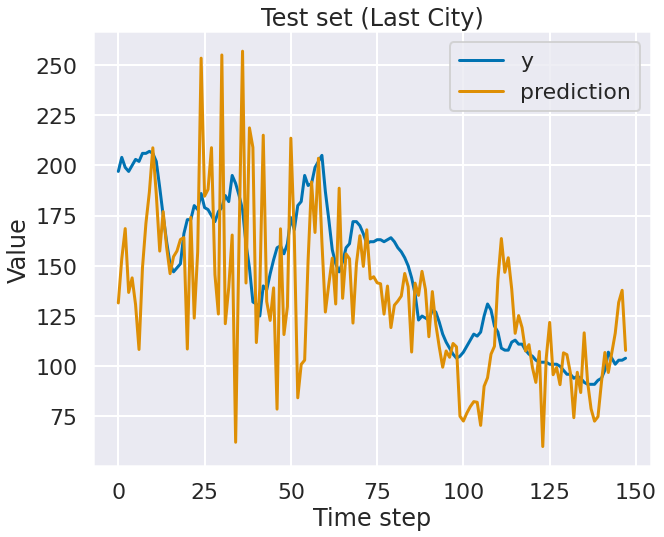

In [ ]:
model = load("/content/best1.pt").to(device)

criterions = [
    nn.L1Loss(),
    nn.MSELoss(),
    make_RMSE()
]
X_test, Y_test = make_dataset(test, window_size, shuffle=False)
X_test, Y_test = reshape_for_cnn(X_test, Y_test)
X_test = X_test.to(device)
Y_test = Y_test.to(device)
test_losses, y, y_pred = testing(X_test, Y_test, model, criterions, min_[TEMPERATURE], max_[TEMPERATURE])
for l, n in zip(test_losses, ["MAE", "MSE", "RMSE"]):
    print(n, l)
plot_predictions("Test set (Last City)", y[3::4,TEMPERATURE], y_pred[3::4,TEMPERATURE])

## Predicting the next week

In [ ]:
model = load("/content/best1.pt").to(device)

In [ ]:
window_size = 20
X_test, Y_test = make_dataset(test, window_size, shuffle=False)
X_test, Y_test = reshape_for_cnn(X_test, Y_test)
X_test = X_test.to(device)
Y_test = Y_test.to(device)
pred = model.predict(X_test[-1], 168)  # Last time step of the last city
pred = scale_back(pred.to("cpu").T, max_, min_).T # We change the shape because of the CNN
X_test = scale_back(X_test[-1].to("cpu").T, max_, min_).T

temperatures = X_test[TEMPERATURE].reshape(-1)
pred_temperatures = pred[TEMPERATURE].reshape(-1)

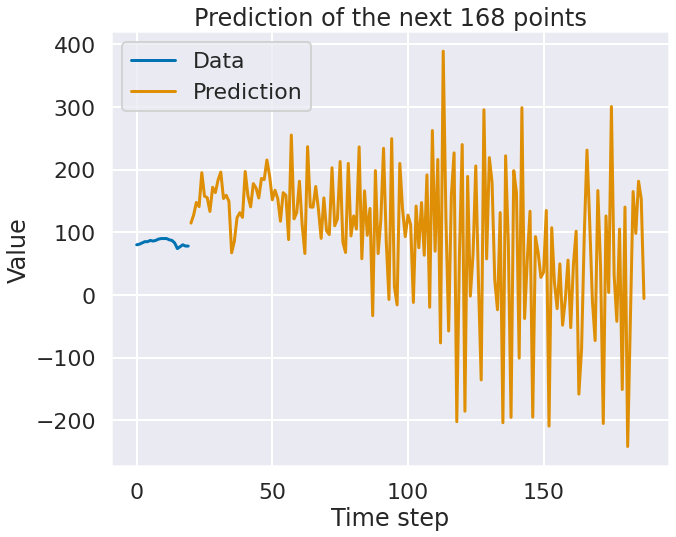

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Prediction of the next 168 points")
plt.plot(temperatures.to("cpu"), label="Data")
plt.plot([i+window_size for i in range(len(pred_temperatures))], pred_temperatures.to("cpu").detach(), label="Prediction")
plt.legend()
plt.xlabel("Time step")
plt.ylabel("Value")
plt.show()

## Important features and model visualization

In [ ]:
model = torch.load("best1.pt").to(device)

window_size = 20
X_test, Y_test = make_dataset(test, window_size, shuffle=False)
X_test, Y_test = reshape_for_cnn(X_test, Y_test)
X_test = X_test.to(device)
Y_test = Y_test.to(device)
print("X:", X_test.shape)
print("Y:", Y_test.shape)

X: torch.Size([592, 5, 20])
Y: torch.Size([592, 5])


We replace the other features with random permulations.

So for feature 1 we have:
f1, f2, f3, f4, f5 -> f1, permutation(f2), permutation(f3), permutation(f4), permutation(f5)

In [ ]:
def mask_zero(data, remove):
    _, f, _ = data.shape
    data = data.clone()
    for i in range(f):
        if i in remove:
            # For all the cities, set the other features to 0
            data[:, i, :] = 0
    return data

def mask_permute(data, remove):
    b, f, l = data.shape
    data = data.clone()
    for i in range(f):
        if i in remove:
            for j in range(b):
                data[j, i, :] = data[j, i, :][torch.randperm(l)]
    return data

def run_fetaure_test(model, X_test, Y_test, repetitions):
    losses = torch.zeros(repetitions)    

    criterions = nn.MSELoss()        

    for i in range(repetitions):
        test_loss, y, y_pred = testing(X_test, Y_test, model, criterions, min_[TEMPERATURE], max_[TEMPERATURE])
        losses[i] = test_loss
    return losses.mean(), losses.std().detach()

In [ ]:
features = {
    "WIND_SPEED": 0,
    "WIND_DIR": 1,
    "TEMPERATURE": 2,
    "DEW_POINT": 3,
    "AIR_PRESSURE": 4,
}
df = pd.DataFrame(columns=["Removed Features", "MSE"])

repetitions = 1

index = 0
for i in range(4):
    combs = itertools.combinations(features.keys(), i+1)
    for j in combs:
        masked_test = X_test.detach().clone()
        masked_test = mask_zero(masked_test, [features[f] for f in j])  # Remove the selected features

        mean, _ = run_fetaure_test(model, masked_test, Y_test, repetitions)
        df.loc[index] = [j, float(mean)]
        index += 1

test_error = 1000
df

,Removed Features,MSE
0,"(WIND_SPEED,)",2856.533203
1,"(WIND_DIR,)",19648.166016
2,"(TEMPERATURE,)",13172.108398
3,"(DEW_POINT,)",19484.216797
4,"(AIR_PRESSURE,)",19954.589844
5,"(WIND_SPEED, WIND_DIR)",16858.748047
6,"(WIND_SPEED, TEMPERATURE)",12142.556641
7,"(WIND_SPEED, DEW_POINT)",14334.765625
8,"(WIND_SPEED, AIR_PRESSURE)",22368.171875
9,"(WIND_DIR, TEMPERATURE)",29306.632812


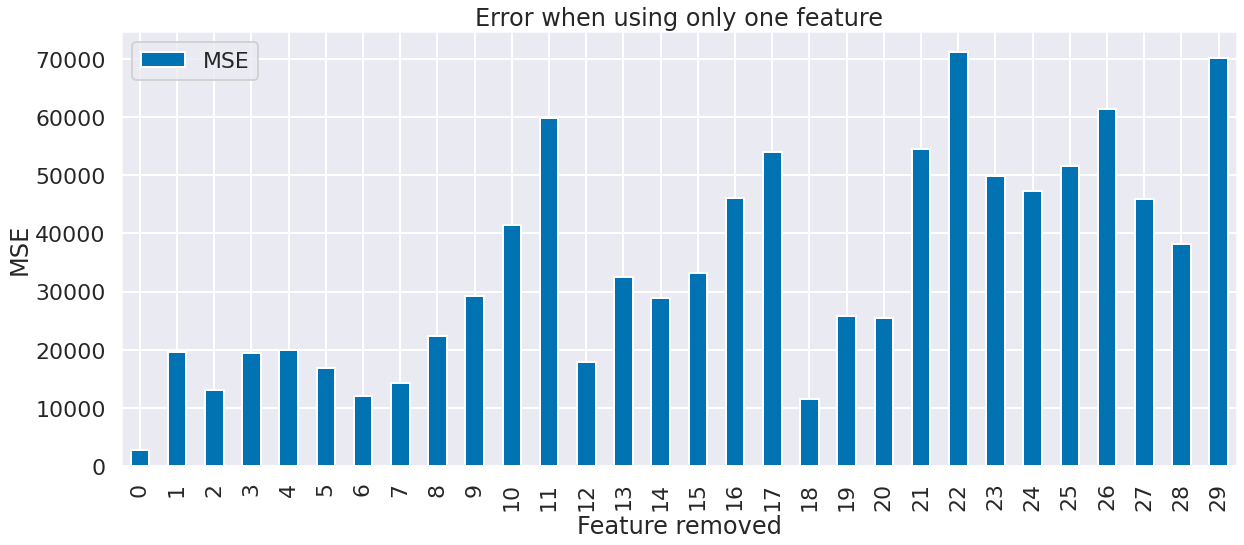

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.title("Error when using only one feature")
plt.xlabel("Feature removed")
plt.ylabel("MSE")
#plt.bar([5], [test_error])
#plt.bar(list(range(5)), means, yerr=errors)
df.plot(kind="bar", ax=ax)
plt.show()